In [1]:
import numpy as np
import pandas as pd

In [2]:
import random

In [3]:
from tqdm import tqdm

In [4]:
import re
import os

In [5]:
from collections import Counter

In [6]:
from sklearn.model_selection import train_test_split

#### PyTorch

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, Subset

import torch.optim as optim

In [8]:
import torchinfo

#### Metrics

In [9]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [10]:
from Levenshtein import distance as levenshtein_distance

#### Visualisation

In [11]:
import matplotlib
import matplotlib.pyplot as plt

In [12]:
import scienceplots

plt.style.use('science')
%config InlineBackend.figure_format = 'retina'

lables_fs = 16
ticks_fs = 12

In [13]:
import seaborn as sns

## Load data

In [14]:
prepared_dir = '../data/prepared'
filename_csv = '01_punct_pushkin.csv'

In [15]:
# load saved dataset
data_df = pd.read_csv(os.path.join(prepared_dir, filename_csv), index_col=0)
data_df.shape

(4456, 4)

In [16]:
pd.options.display.max_colwidth = 150
data_df.sample(5)

,input,input_lemma,input_pos,target
3233,он бы всех до единого переловил да и сам дубровский не вывернулся б и не откупился,он бы весь до единый переловить да и сам дубровский не вывернуться б и не откупиться,PRON AUX PRON ADP ADJ NOUN CCONJ CCONJ ADJ VERB PART VERB AUX CCONJ PART VERB,S S S S S C S S S S S S S S S P
435,конечно отвечал швабрин вы своею кровью будете отвечать мне за вашу дерзость но за нами вероятно станут присматривать,конечно отвечать швабрин вы свой кровь быть отвечать я за ваш дерзость но за мы вероятно стать присматривать,ADV VERB VERB PRON ADJ NOUN AUX VERB PRON ADP DET NOUN CCONJ ADP PRON ADV VERB NOUN,C S C S S S S S S S S C S S C C S P
3262,я не могу дормир в потемках,я не мочь дормир в потемки,PRON PART VERB VERB ADP NOUN,S S C C S P
4346,заря едва занималась как он уже был одет,заря едва заниматься как он уже быть одеть,NOUN PART VERB SCONJ PRON ADV AUX VERB,S S C S S S S P
1432,меня привезли в крепость уцелевшую посереди сгоревшего города,я привезти в крепость уцелеть посереди сгореть город,PRON VERB ADP NOUN ADJ ADJ VERB NOUN,S S S C S S S P


## Dataset

**In that baseline** we will use sequences of _speech parts_ (`input_pos`) as input

In [17]:
# splitting_random_state = 78
# test_size = 0.25

# X_train, X_test, y_train, y_test = train_test_split(
#     data_df['input_pos'], data_df['target'],
#     test_size=test_size,
#     random_state=splitting_random_state
# )

# print(f'Train size : {X_train.shape[0]}')
# print(f'Test size  : {X_test.shape[0]}')

In [18]:
pos_to_ix = {}  # part of speech (`pos`) to index dict

for pos_seq in data_df['input_pos']:
    for pos in pos_seq.split(' '):
        if pos not in pos_to_ix:
            pos_to_ix[pos] = len(pos_to_ix)

print(pos_to_ix)

{'ADP': 0, 'DET': 1, 'NOUN': 2, 'VERB': 3, 'PRON': 4, 'ADJ': 5, 'ADV': 6, 'CCONJ': 7, 'AUX': 8, 'SCONJ': 9, 'PART': 10, 'X': 11, 'NUM': 12, 'PROPN': 13, 'PUNCT': 14}


In [19]:
len(pos_to_ix)

15

In [20]:
tag_to_ix = {
    'S':  0, # space (` `)
    'C':  1, # comma (`,`)
    'P':  2, # period (`.`)
    'EX': 3, # exclamation (`!`)
    'Q':  4  # question (`?`)
}

ix_to_tag = {ix: tag for tag, ix in tag_to_ix.items()}

In [21]:
data_df.iloc[10]['input_pos']

'VERB SCONJ NOUN VERB PRON DET NOUN'

In [22]:
class PosSeqDataset(Dataset):

    def __init__(self, df, pos_to_ix, tag_to_ix, train_ratio=0.8, split_seed=None):

        self.df = df  # dataframe with data
        
        self.pos_to_ix = pos_to_ix
        self.tag_to_ix = tag_to_ix

        self.train_ratio = train_ratio
        self.split_seed = split_seed

        self.data_splitting()

    def data_splitting(self):
        n_all_sentences = self.df.shape[0]  # numer of all sentences

        self.train_ids, self.test_ids = train_test_split(
            np.arange(n_all_sentences),  # array of all indecies
            train_size=self.train_ratio, 
            random_state=self.split_seed  # can be None
        )

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, ind):
        input_seq, target_seq = self.df.iloc[ind]['input_pos'], self.df.iloc[ind]['target']

        input_to_ix = torch.LongTensor([self.pos_to_ix[pos] for pos in input_seq.split(' ')])
        target_to_ix = torch.LongTensor([self.tag_to_ix[mark] for mark in target_seq.split(' ')])
        
        return input_to_ix, target_to_ix

In [23]:
splitting_random_state = 78
test_ratio = 0.25

data_ds = PosSeqDataset(
    data_df,
    pos_to_ix, tag_to_ix,
    train_ratio=1 - test_ratio,
    split_seed=splitting_random_state
)

In [24]:
data_ds[5]

(tensor([2, 2, 3, 4, 0, 4, 6, 2, 5, 5, 2]),
 tensor([0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 2]))

### Data splitting

In [25]:
# DATA SPLITTING (by ready indices)
train_ds = Subset(data_ds, data_ds.train_ids)
test_ds = Subset(data_ds, data_ds.test_ids)

print(f'Train size : {len(train_ds)}')
print(f'Test size  : {len(test_ds)}')

Train size : 3342
Test size  : 1114


In [26]:
# DATALOADERS
train_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=1,
    shuffle=True,
    # num_workers=2,
    drop_last=False,
)
val_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)

## Model

In [27]:
class LSTM_POS(nn.Module):

    def __init__(self, vocab_size, num_tags, embedding_dim, hidden_dim, lstm_num_layers=1):
        super().__init__()
        self.vocab_size = vocab_size  # number of POS
        self.tagset_size = num_tags  # number of punctuation marks to predict

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim  # lstm hidden

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)

        self.lstm_h = None  # hidden state
        self.lstm_num_layers = lstm_num_layers
        
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim // 2,  # for bidirectional LSTM
            num_layers=self.lstm_num_layers,
            bidirectional=True
        )

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)


    def forward(self, sentences):
        batch_size = sentences.shape[0]
        out = self.word_embeds(sentences)
        
        out, self.lstm_h = self.lstm(out, self.lstm_h)
        # self.lstm_h = lstm_h.detach()
        
        out = torch.stack(
            [
                F.log_softmax(self.hidden2tag(out[i]), dim=-1)  # for NLLLoss
                for i in range(out.shape[0])
            ]
        )
        
        return out

    def reset_hidden(self, seq_len, device):
        h1 = torch.zeros(self.lstm_num_layers*2, seq_len, self.hidden_dim // 2).to(device)
        h2 = torch.zeros(self.lstm_num_layers*2, seq_len, self.hidden_dim // 2).to(device)
        self.lstm_h = (h1, h2)

In [28]:
model_info = LSTM_POS(
    vocab_size=len(pos_to_ix),
    num_tags=len(tag_to_ix), 
    embedding_dim=3,
    hidden_dim=100,
    lstm_num_layers=2
)

len_sent = 14
batch_size = 5
torchinfo.summary(model_info, (batch_size, len_sent), dtypes=[torch.long], device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
LSTM_POS                                 [5, 14, 5]                --
├─Embedding: 1-1                         [5, 14, 3]                45
├─LSTM: 1-2                              [5, 14, 100]              82,800
├─Linear: 1-3                            [14, 5]                   505
├─Linear: 1-4                            [14, 5]                   (recursive)
├─Linear: 1-5                            [14, 5]                   (recursive)
├─Linear: 1-6                            [14, 5]                   (recursive)
├─Linear: 1-7                            [14, 5]                   (recursive)
Total params: 83,350
Trainable params: 83,350
Non-trainable params: 0
Total mult-adds (M): 5.83
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.33
Estimated Total Size (MB): 0.39

### Loops for training and evaluating the model

In [29]:
def train_fn(model, data_loader, loss_func, optimizer, device='cpu', show_process=False):
    model.train()  # activate 'train' mode of a model
    train_loss = []  # to store loss for each batch

    for X, y in tqdm(data_loader, total=len(data_loader),
                     desc='train', position=0,
                     leave=True, disable=not show_process):   # [X, y] - batch
        X, y = X.to(device), y.to(device)
        
        seq_len = X.shape[1]  # we will use bs = 1
        model.reset_hidden(seq_len, device)
        
        optimizer.zero_grad()
        y_hat = model(X)  # for rnn Neural Network output: [prediction, hidden]
        y_hat = y_hat.permute(0, 2, 1)  # torch.Tensor(torch.argmax(y_hat, dim=2))
        
        loss = loss_func(y_hat, y)  # loss calculation for the batch
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())  # accumulate losses for batches

    return np.mean(train_loss)  # return mean loss of the epoch


def validate_fn(model, data_loader, loss_func, device='cpu', show_process=False):
    model.eval()  # activate 'eval' mode of a model
    val_loss = []  # to store loss for each batch

    for X, y in tqdm(data_loader, total=len(data_loader),
                     desc='validation', position=0,
                     leave=True, disable=not show_process):   # [X, y] - batch
        X, y = X.to(device), y.to(device)

        seq_len = X.shape[1]  # we will use bs = 1
        model.reset_hidden(seq_len, device)
        
        with torch.no_grad():
            y_hat = model(X)  # for rnn Neural Network output: [prediction, hidden]
            y_hat = y_hat.permute(0, 2, 1)
            
            loss = loss_func(y_hat, y)

        val_loss.append(loss.item())  # accumulate losses for batches

    return np.mean(val_loss)

### Training

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
lstm_pos = LSTM_POS(
    vocab_size=len(pos_to_ix),
    num_tags=len(tag_to_ix), 
    embedding_dim=3,
    hidden_dim=64,
    lstm_num_layers=1
)

In [32]:
optimizer = torch.optim.RMSprop(lstm_pos.parameters(), lr=0.5)  # , weight_decay=1e-4
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.2,  # default: 0.1
    patience=5,  # default: 10
    verbose=False
)

/Users/giyuu/science-phd/git-projects/mini-projects/itmo_nlp-course-24/venv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [33]:
# define weights for the loss function?
train_marks_count = {ix: 0 for ix in tag_to_ix.values()}

for X, y in train_ds:
    for ix in y:
        train_marks_count[ix.item()] += 1

train_marks_count

{0: 33866, 1: 7150, 2: 3027, 3: 136, 4: 179}

In [34]:
max_count = max(train_marks_count.values())

train_marks_weights = {ix: max_count / train_marks_count[ix] for ix in tag_to_ix.values()}
punc_weights = torch.Tensor(list(train_marks_weights.values()))

print(train_marks_weights)

{0: 1.0, 1: 4.736503496503497, 2: 11.18797489263297, 3: 249.01470588235293, 4: 189.19553072625698}


In [35]:
loss_func = nn.NLLLoss(weight=punc_weights)  # loss function with weights

In [36]:
%%time

n_epochs = 100
show_process = True
print_each = 5

train_loss_history = []
test_loss_history = []

for epoch in range(n_epochs):
    if show_process and ((epoch == 0) or ((epoch + 1) % print_each == 0)):
        print(f'Epoch {epoch + 1}:', end='')
    mean_train_loss = train_fn(lstm_pos, train_loader, loss_func,
                               optimizer,
                               device=device,
                               show_process=False
                              )  # train the model
    mean_val_loss = validate_fn(lstm_pos, val_loader, loss_func,
                                device=device,
                                show_process=False
                               )  # evaluate the model

    train_loss_history.append(mean_train_loss)  # loss history
    test_loss_history.append(mean_val_loss)
    
    if show_process and ((epoch == 0) or ((epoch + 1) % print_each == 0)):  # bs=1
        log_info = (f'\ttrain - {mean_train_loss:.4f}; ' +
                    f'\tval - {mean_val_loss:.4f}'
                   )
        print(log_info)

    if scheduler:
        scheduler.step(mean_val_loss)

Epoch 1:	train - 9.5787; 	val - 5.5228
Epoch 5:	train - 7.7271; 	val - 7.8969
Epoch 10:	train - 2.0114; 	val - 2.7892
Epoch 15:	train - 1.9873; 	val - 1.9032
Epoch 20:	train - 1.9935; 	val - 3.5312
Epoch 25:	train - 1.3494; 	val - 1.3951
Epoch 30:	train - 1.3463; 	val - 1.4037
Epoch 35:	train - 1.2574; 	val - 1.3362
Epoch 40:	train - 1.2576; 	val - 1.3418
Epoch 45:	train - 1.2393; 	val - 1.3296
Epoch 50:	train - 1.2350; 	val - 1.3267
Epoch 55:	train - 1.2341; 	val - 1.3266
Epoch 60:	train - 1.2349; 	val - 1.3272
Epoch 65:	train - 1.2336; 	val - 1.3254
Epoch 70:	train - 1.2335; 	val - 1.3249
Epoch 75:	train - 1.2339; 	val - 1.3247
Epoch 80:	train - 1.2344; 	val - 1.3247
Epoch 85:	train - 1.2344; 	val - 1.3247
Epoch 90:	train - 1.2344; 	val - 1.3247
Epoch 95:	train - 1.2344; 	val - 1.3247
Epoch 100:	train - 1.2344; 	val - 1.3247
CPU times: user 9min 7s, sys: 16min 40s, total: 25min 48s
Wall time: 3min 37s


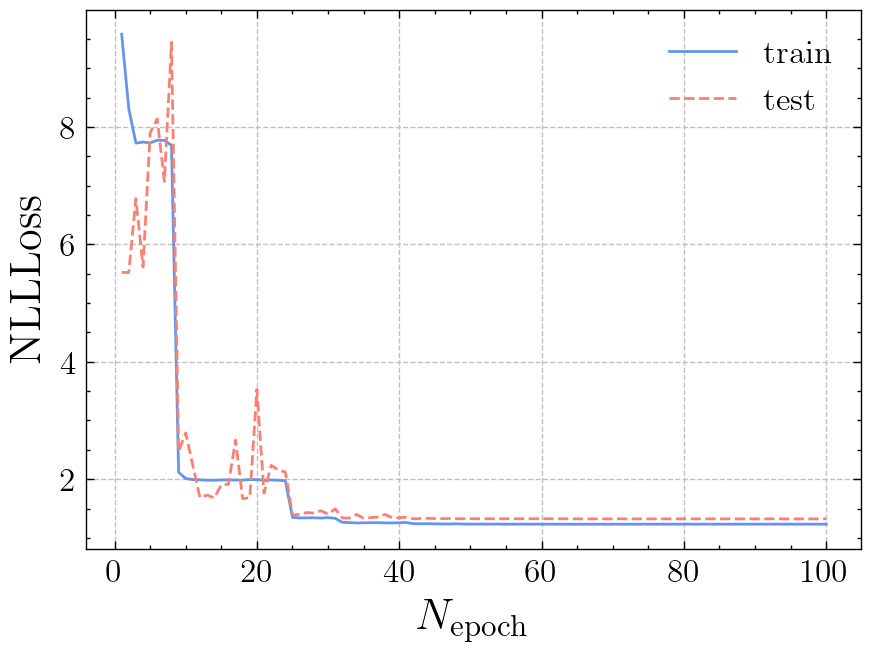

In [37]:
# plot process
fig, (ax0) = plt.subplots(1, 1, figsize=(5, 3.5))

ax0.plot(
    np.arange(1, n_epochs + 1), train_loss_history, 
    c='cornflowerblue', linestyle='solid', lw=1, label='train'
)
ax0.plot(
    np.arange(1, n_epochs + 1), test_loss_history, 
    c='salmon', linestyle='dashed', lw=1, label='test'
)

ax0.set_ylabel('NLLLoss', fontsize=lables_fs)
ax0.set_xlabel(r'$N_{\text{epoch}}$', fontsize=lables_fs)

ax0.tick_params(axis='both', which='major', labelsize=ticks_fs)
ax0.set_facecolor('w')
# ax0.axis('equal')

ax0.grid(True)
ax0.grid(color='silver', linestyle='--', linewidth=0.5)

lg = ax0.legend(loc='upper right', fontsize=ticks_fs)

plt.show() 

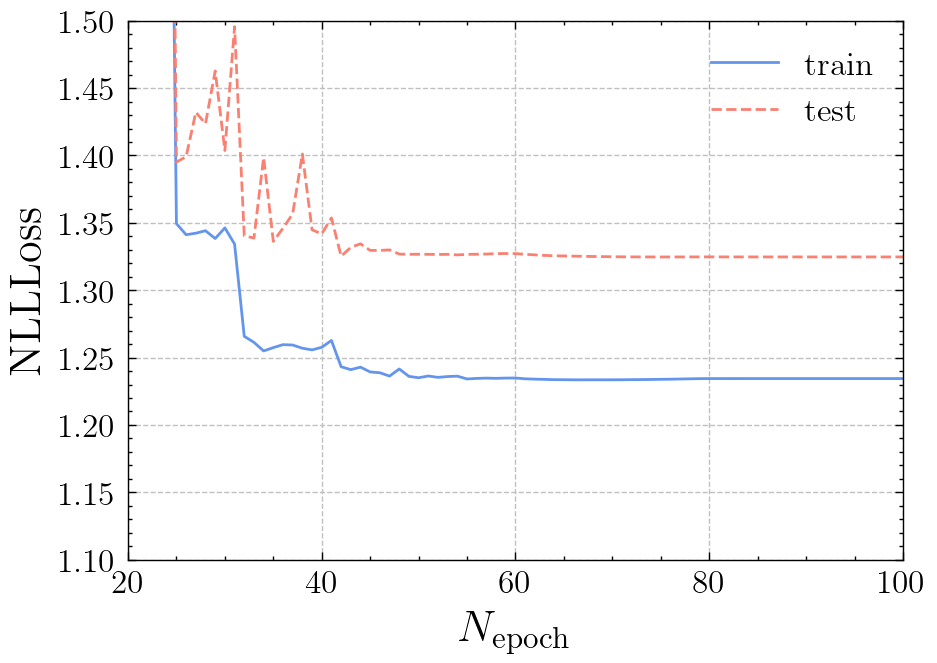

In [40]:
fig, (ax0) = plt.subplots(1, 1, figsize=(5, 3.5))

ax0.plot(
    np.arange(1, n_epochs + 1), train_loss_history, 
    c='cornflowerblue', linestyle='solid', lw=1, label='train'
)
ax0.plot(
    np.arange(1, n_epochs + 1), test_loss_history, 
    c='salmon', linestyle='dashed', lw=1, label='test'
)

ax0.set_ylabel('NLLLoss', fontsize=lables_fs)
ax0.set_xlabel(r'$N_{\text{epoch}}$', fontsize=lables_fs)

ax0.tick_params(axis='both', which='major', labelsize=ticks_fs)
ax0.set_facecolor('w')

ax0.set_xlim([20, 100])
ax0.set_ylim([1.1, 1.5])

ax0.grid(True)
ax0.grid(color='silver', linestyle='--', linewidth=0.5)

lg = ax0.legend(loc='upper right', fontsize=ticks_fs)

plt.show() 

### Metrics

In [41]:
all_test_targets = []  # by markers
all_test_preds = []

lstm_pos.eval()

for X, y in val_loader:
    
    X, y = X.to(device), y.to(device)
    seq_len = X.shape[1]  # we will use bs = 1
    lstm_pos.reset_hidden(seq_len, device)

    with torch.no_grad():
        y_hat = lstm_pos(X)
        pred = torch.argmax(y_hat, dim=2)

    all_test_targets.append(' '.join([ix_to_tag[ix.item()] for ix in y[0]]))
    all_test_preds.append(' '.join([ix_to_tag[ix.item()] for ix in pred[0]]))

In [42]:
target_vs_pred_df = pd.DataFrame()

target_vs_pred_df['target'] = all_test_targets
target_vs_pred_df['predicted'] = all_test_preds

#### Precision, Recall, $F_1$

In [43]:
def return_separate_punct(target_vs_pred_df):
    test_all_punc_target = []  # list of all punctuation
    test_all_punc_preds = []
    
    for target_this, predicted_this in zip(target_vs_pred_df['target'], target_vs_pred_df['predicted']):
        test_all_punc_target.extend(target_this.split(' '))
        test_all_punc_preds.extend(predicted_this.split(' '))
    
    assert len(test_all_punc_target) == len(test_all_punc_preds)
    
    return test_all_punc_target, test_all_punc_preds

In [44]:
test_all_punc_target, test_all_punc_preds = return_separate_punct(target_vs_pred_df)

cm = confusion_matrix(test_all_punc_target, test_all_punc_preds)
# precision = TP / (TP + FP)
precision = precision_score(test_all_punc_target, test_all_punc_preds, average=None, zero_division=np.nan)
# recall = TP / (TP + FN)
recall = recall_score(test_all_punc_target, test_all_punc_preds, average=None, zero_division=np.nan)
# f1 = 2TP / (2TP + FP + FN)
f1 = f1_score(test_all_punc_target, test_all_punc_preds, average=None)

In [45]:
END_PUNC = ['P', 'EX', 'Q']
INTR_PUNC = ['S', 'C']

NAMES_PUNC = {
    'S': 'space (` `)',
    'C': 'comma (`,`)',
    'P': 'period (`.`)',
    'EX': 'exclamation (`!`)',
    'Q': 'question (`?`)'
}

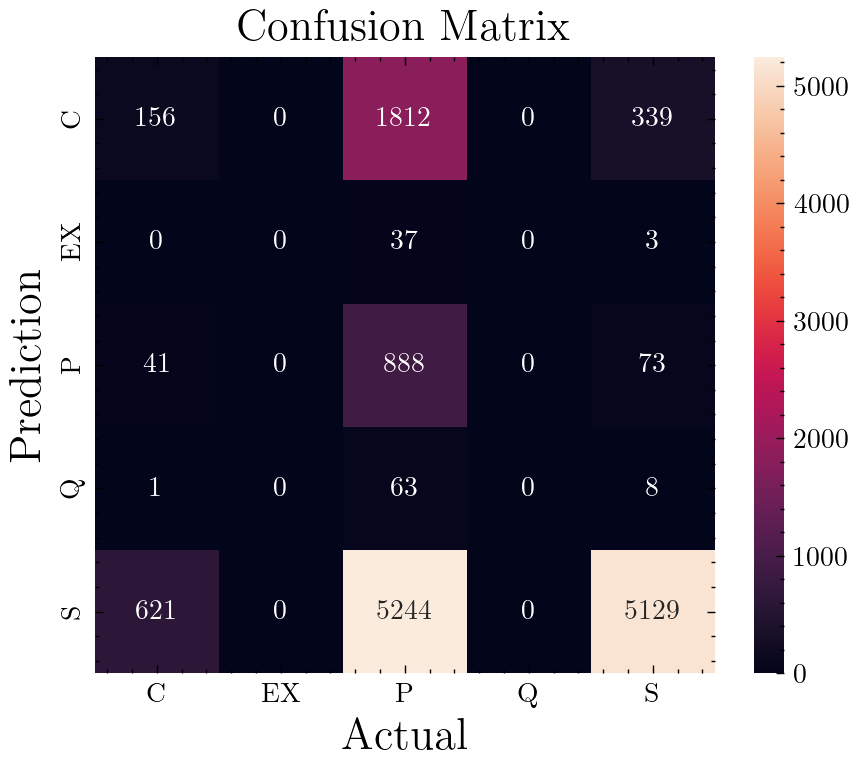

In [46]:
fig, ax = plt.subplots(figsize=(5, 4))

# create a confusion matrix
# cm = confusion_matrix(test_all_punc_target, test_all_punc_preds) / n_experiments
classes = sorted(END_PUNC + INTR_PUNC)  # alphabetic order

# plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.ylabel('Prediction', fontsize=lables_fs)
plt.xlabel('Actual', fontsize=lables_fs)
plt.title(f'Confusion Matrix', fontsize=lables_fs)
plt.show()

In [47]:
metrics_names = ['Precision', 'Recall', 'F1 score']
metrics = {'Precision': precision, 'Recall': recall, 'F1 score': f1}
col_w = 18

print(' ' * col_w + '|' + ''.join([f"{NAMES_PUNC[token] + (col_w - len(NAMES_PUNC[token])) * ' '}|" for token in classes]))  # header
print(''.join(['-' * col_w + '|' for _ in range(len(classes) + 1)]) )
for ind, metric_name in enumerate(metrics_names):
    row = f"{metric_name + (col_w - len(metric_name)) * ' '}|"
    for score in metrics[metric_name]:
        score_str = f'{score:.6f}'
        row += f"{score_str + (col_w - len(score_str)) * ' '}|"
    print(row)

                  |comma (`,`)       |exclamation (`!`) |period (`.`)      |question (`?`)    |space (` `)       |
------------------|------------------|------------------|------------------|------------------|------------------|
Precision         |0.190476          |nan               |0.110393          |nan               |0.923811          |
Recall            |0.067620          |0.000000          |0.886228          |0.000000          |0.466527          |
F1 score          |0.099808          |0.000000          |0.196330          |0.000000          |0.619969          |


#### Levenshtein distance

In [48]:
target_vs_pred_df['levenshtein'] = target_vs_pred_df.apply(
    lambda row: levenshtein_distance(row.target, row.predicted),
    axis = 1
)

In [49]:
print(f"\tMean: {target_vs_pred_df['levenshtein'].mean()}")
print(f"\tMIN : {target_vs_pred_df['levenshtein'].min()}")
print(f"\tMAX : {target_vs_pred_df['levenshtein'].max()}")

	Mean: 7.433572710951526
	MIN : 0
	MAX : 19
